# Prototype 02 > Experiment 01

In [3]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [3]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [4]:
# Global Dependencies
from src.custom_types import Behavior
from src.data_provider import DataProvider
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior, get_pretrained_ae

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#from prototypes.prototype_02.agent import Agent
#from prototypes.prototype_02.client import Client
from prototypes.prototype_02.enums import Execution, Evaluation
#from prototypes.prototype_02.server import Server
#from prototypes.prototype_02.experiment import Experiment

In [6]:
from enum import Enum

'''
class Behavior(Enum):
    NORMAL = "normal"
    ROOTKIT_BDVL = "bdvl"
    ROOTKIT_BEURK = "beurk"
    CNC_BACKDOOR_JAKORITAR = "backdoor_jakoritar"
    CNC_THETICK = "the_tick"
    CNC_OPT1 = "data_leak_1"
    CNC_OPT2 = "data_leak_2"
    RANSOMWARE_POC = "ransomware_poc"
'''

'''
class MTDTechnique(Enum):
    CONTINUE = "continue"
    CNC_IP_SHUFFLE = "cnc_ip_shuffle"
    ROOTKIT_SANITIZER = "rootkit_sanitizer"
    RANSOMWARE_DIRECTORY_TRAP = "ransomware_directory_trap"
    RANSOMWARE_FILE_EXTENSION_HIDE = "ransomware_file_extension_hide"
'''


class MTDTechnique(Enum):
    CNC_IP_SHUFFLE = "cnc_ip_shuffle"
    ROOTKIT_SANITIZER = "rootkit_sanitizer"
    RANSOMWARE_DIRTRAP = "ransomware_directory_trap"
    RANSOMWARE_FILE_EXT_HIDE = "ransomware_file_extension_hide"
    
actions = [
    MTDTechnique.CNC_IP_SHUFFLE,
    MTDTechnique.ROOTKIT_SANITIZER,
    MTDTechnique.RANSOMWARE_DIRTRAP,
    MTDTechnique.RANSOMWARE_FILE_EXT_HIDE
]

#mitigated_by = {
#    0: [Behavior.NORMAL],
#    1: [Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_THETICK, Behavior.CNC_OPT1, Behavior.CNC_OPT2, Behavior.NORMAL],
#    2: [Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK, Behavior.NORMAL],
#    3: [Behavior.RANSOMWARE_POC, Behavior.NORMAL],
#    4: [Behavior.RANSOMWARE_POC, Behavior.NORMAL],
#}

mitigated_by = {
    0: [Behavior.CNC_BACKDOOR_JAKORITAR, Behavior.CNC_THETICK, Behavior.CNC_OPT1, Behavior.CNC_OPT2],
    1: [Behavior.ROOTKIT_BDVL, Behavior.ROOTKIT_BEURK],
    2: [Behavior.RANSOMWARE_POC],
    3: [Behavior.RANSOMWARE_POC],
}

In [7]:
def split_training_data(training_data, n_strides):
    strides = []
    for i in range(n_strides):
        strides.append(dict())

    for key, value in training_data.items():
        #print(f"{key} => {len(value)}")
        array_split = np.array_split(value, n_strides)
        for i in range(n_strides):
            strides[i][key] = array_split[i]
        
    return strides

In [8]:
import numpy as np

def get_test_dataset(test_data):
    test_data_dict = {}

    for behavior, behavior_data in test_data.items():
        if behavior == Behavior.NORMAL:
            behavior_data = behavior_data[:2800]
            #continue
        else:
            behavior_data = behavior_data[:400]

        test_data_dict[behavior] = behavior_data

    return test_data_dict

In [9]:
import numpy as np

def multiclass_imbalance_degree(M):
    N = np.sum(M)
    n_cs = np.sum(M, axis=0)

    C = len(n_cs)
    MID = 0
    for n_c in n_cs:
        relative_label_frequency =  n_c / N
        MID+=relative_label_frequency*np.emath.logn(C, C*relative_label_frequency)   
    return round(MID, 4)

In [10]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def mean_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_two_norm = norm(L, 2)
    n = lis.shape[0]

    mean_cosine_similarity = 0
    for li in lis:
        mean_cosine_similarity += (1 / n) * (np.dot(L,li) / (L_two_norm * norm(li, 2)))

    return mean_cosine_similarity

In [11]:
from numpy.linalg import norm

'''
    This function computes the mean cosine similarity 
    for a numpy 2d matrix
    For each client one row is added to the matrix
    Each row contains the sample frequency for each label as columns
'''
def weighted_cosine_similarity(lis):
    L = np.sum(lis, axis=0)
    L_one_norm = norm(L, 1)
    L_two_norm = norm(L, 2)
    #n = lis.shape[0]

    cosine_similarity = 0
    for li in lis:
        li_one_norm = norm(li, 1)
        li_two_norm = norm(li, 2)
        cosine_similarity +=  (li_one_norm/li_two_norm) * np.dot(L,li) 

    weighted_cosine_similarity = 1/(L_one_norm * L_two_norm)*cosine_similarity
    return round(weighted_cosine_similarity, 4)

In [12]:
def calculate_balance_metrics(sampling_probability_1, sampling_probabiliy_2, N):
    NR_SAMPLES_1 = np.array(list(sampling_probability_1.values()))*N
    NR_SAMPLES_2 = np.array(list(sampling_probabiliy_2.values()))*N

    sample_matrix = np.vstack([NR_SAMPLES_1, NR_SAMPLES_2])

    print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
    print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

In [13]:
import os
import sys
import torch
import numpy as np
from src.data_provider import DataProvider
from tabulate import tabulate

def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)
    return X_train, X_valid
    
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=3, scaling_minmax=True,
                                                                         scale_normal_only=True)
normal_data = training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

N_FEATURES = normal_data.shape[1] -1
flattend_test_data = np.empty([0, N_FEATURES+1])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

evaluation_data = {}
for behavior, behavior_data in training_data.items():
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

['tasks', 'tasksSleeping', 'tasksZombie', 'tasksRunning', 'ramFree', 'ramUsed', 'ramCache', 'memAvail', 'numEncrypted', 'iface0RX', 'iface0TX', 'iface1RX', 'iface1TX', 'cpuSystem', 'block:block_dirty_buffer', 'cpuSoftIrq', 'cs', 'cpu-migrations', 'irq:softirq_entry', 'kmem:kmem_cache_alloc', 'kmem:kmem_cache_free', 'random:urandom_read', 'raw_syscalls:sys_enter', 'raw_syscalls:sys_exit', 'sched:sched_switch', 'sched:sched_wakeup', 'skb:consume_skb', 'timer:hrtimer_start', 'writeback:global_dirty_state', 'cpuIdle', 'cpuIowait', 'block:block_bio_backmerge', 'block:block_touch_buffer', 'clk:clk_set_rate', 'irq:irq_handler_entry', 'jbd2:jbd2_start_commit', 'kmem:mm_page_alloc', 'kmem:mm_page_free', 'preemptirq:irq_enable', 'sock:inet_sock_set_state']
40
type(rdf): <class 'pandas.core.frame.DataFrame'>
rdf.columns: Index(['cpuUser', 'cpuSystem', 'cpuIdle', 'cpuIowait', 'cpuSoftIrq', 'tasks',
       'tasksRunning', 'tasksSleeping', 'tasksZombie', 'ramFree', 'ramUsed',
       'ramCache', 'mem

In [103]:
from prototypes.prototype_02.autoencoder import AutoEncoder
from prototypes.prototype_02.autoencoder_utils import RMSELoss, initial_autoencoder_architecture

In [104]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(N_FEATURES), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=False)
autoencoder.evaluate(n_std=20, tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        2515 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &   

In [184]:
# Sampling from distribution has to be added here.       
from typing import Dict, Tuple, List
from collections import defaultdict
#from src.custom_types import Behavior, MTDTechnique, actions, mitigated_by
from scipy import stats
from tabulate import tabulate
import torch
import numpy as np
import pandas as pd
import os
import random
from functools import reduce

class Environment:

    def __init__(self, 
                 environment_id: int,
                 training_data: Dict[Behavior, np.ndarray] = None,
                 state_interpreter: AutoEncoder = None,
                 n_state_samples: int = 1,
                 normality_probability: float = 0.5,
                 sampling_probabilities: Dict[Behavior, float] = None,
                 verbose=False):
        
        #print(f"len(actions): {len(actions)}")
        self.environment_id = environment_id
        self.n_state_samples = n_state_samples
        self.training_data = training_data
        self.normality_probability = normality_probability
        self.current_state: np.array = None
        self.observation_space_size: int = len(self.training_data[list(self.training_data.keys())[0]][0][:-1])
        self.actions: List[int] = [i for i in range(len(MTDTechnique))]
        self.state_interpreter = state_interpreter
        self.reset_to_behavior = None
        
        self.nr_fps = 0
        self.nr_fns = 0
        self.total_nr_steps = 0
        self.total_nr_episodes = 0
        
        #print(normality_probability)
        #for key, value in training_data.items():
        #    print(f"{key}: {len(value)}")
        if sampling_probabilities != None:
            sum_of_percentages = reduce(lambda x, y: x+y, sampling_probabilities.values())
            assert round(sum_of_percentages, 4) == 1, f"Make sure that all percentages sum to 100. Right now it is {sum_of_percentages}"
        self.sampling_probabilities = sampling_probabilities
        
        self.verbose = verbose

    def sample_initial_decision_state(self):
        """i.e. for starting state of an episode,
        (with replacement; it is possible that the same sample is chosen multiple times)"""
        #if np.random.random_sample() < self.normality_probability:
        #    #print("sampling normal behavior")
        #    sampled_behavior = Behavior.NORMAL
        #    #print("Using normal behavior")
        #else:
        if self.sampling_probabilities != None: 
            # Sample according to given sampling probabilities
            attacks = [b for b in list(self.sampling_probabilities.keys())]
            sampling_probabilities = self.sampling_probabilities.values()
            sampled_behavior = random.choices(attacks, weights=sampling_probabilities, k=1)[0]
        else:
            # Randomly sample an attack
            sampled_behavior = random.choice([behavior for behavior in self.training_data.keys()])

        # All samples for the chosen behavior
        state_samples = self.training_data[sampled_behavior]
        
        # Select only one sample to return for the chosen behavior
        selected_state_sample = state_samples[np.random.randint(state_samples.shape[0], size=self.n_state_samples), :]
        return selected_state_sample

    def sample_behavior(self, b: Behavior):
        behavior_data = self.training_data[b]
        return behavior_data[np.random.randint(behavior_data.shape[0], size=self.n_state_samples), :]

    def step(self, action: int):
        self.total_nr_steps+=1
        
        #self.reset_to_behavior = None
        
        current_behavior = self.current_state[0, -1]
        #print(current_behavior)
        #print(f"action: {action}")
        #print(f"current_behavior: {current_behavior}")
        #print(f"mitigated_by[action]: {mitigated_by[action]}")
        if current_behavior in mitigated_by[action]:
            # Correct MTD was chosen
            # => Afterstate Normal
            #if self.verbose:
            #    print("Correct MTD chosen according to supervisor")
            next_state = (self.sample_behavior(Behavior.NORMAL))
            
            # ae predicts too many false positives: episode should not end, but behavior is normal (because MTD was correct)
            # note that this should not happen, as ae should learn to recognize normal behavior with near perfect accuracy

            if self.state_is_classified_normal(next_state[:, :-1].astype(np.float32)):
                # True Negative (TN)
                # Afterstate Normal, Classified Normal
                reward = self.calculate_reward(True)
                isTerminalState = True
            else:
                # raise UserWarning("Should not happen! AE fails to predict majority of normal samples")
                # False Positive (FP)
                # Afterstate Normal, Classified Abnormal
                self.nr_fps+=1
                if self.verbose:
                    print(f"False Positive: ({current_behavior} misclassified as ABNORMAL) by anomaly detector")
                reward = self.calculate_reward(False)
                #reward=1
                isTerminalState = False

        else:
            # Incorrect MTD was chosen
            # => Afterstate Abnormal
            #if self.verbose:
            #    print("Incorrect MTD chosen according to supervisor")
            
            next_state = (self.sample_behavior(current_behavior))
            
            # False Negative
            # ae predicts a false negative: episode should end,  but behavior is not normal (because MTD was incorrect)
            # in this case, the next episode should start again with current_behavior

            if self.state_is_classified_normal(next_state[:, :-1].astype(np.float32)):
                # False Negative (FN)
                # Afterstate Abnormal, Classified Normal
                if self.verbose and next_state != Behavior.NORMAL:
                    self.nr_fns+=1
                    print(f"False Negative: ({current_behavior} misclassified as NORMAL) by anomaly detector")
                    self.reset_to_behavior = current_behavior
                reward = self.calculate_reward(True)
                isTerminalState = True
            else:
                # True Positive (TP)
                # Afterstate Abnormal, Classified Abnormal
                #if self.verbose & next_state == Behavior.NORMAL:
                #    print(f"False Negative: ({current_behavior} misclassified as NORMAL) by anomaly detector")
                reward = self.calculate_reward(False)
                # reward=-1
                isTerminalState = False

        self.current_state = next_state
        if self.n_state_samples > 1:
            next_state = np.expand_dims(next_state[0, :], axis=0)  # throw away all but one transition for better decorrelation

        return next_state, reward, isTerminalState

    def state_is_classified_normal(self, state_samples):
        # Classified as normal for < 0.5
        # Otherwise considered abnormal
        return (torch.sum(self.state_interpreter.predict(state_samples, n_std=20)) / len(state_samples)) <= 0.5
      
    '''
        
    '''
    def reset(self):
        #print(f"resetting to {self.reset_to_behavior}")
        # In case of wrongful termination of an episode due to a false negative,
        # next episode should start with the given behavior again
        if self.reset_to_behavior:
            #if self.verbose:
            #print(f"Called in {self.total_nr_steps}, Resetting to behavior: {self.reset_to_behavior}")
            self.current_state = self.sample_behavior(self.reset_to_behavior)
            self.reset_to_behavior = None
            # WARNING:
            # if the behavior to reset to is never detected as an anomaly,
            # it could get stuck in an endless loop here
        else:
            self.current_state = self.sample_initial_decision_state()

        #b = self.current_state[0, -1]
        #if not self.state_is_classified_normal(self.current_state[:, :-1].astype(np.float32)):
        #    # FP/TP - start training
        #    # below must be here, otherwise it's possible that there is a false negative and the next episode starts with a different behavior
        #    self.reset_to_behavior = None
        #    break
        
        #print(f"did reset to {self.current_state[:,-1]}")
        return np.expand_dims(self.current_state[0, :], axis=0)

    def calculate_reward(self, success):
        if success:
            return 1
        else:
            return -1
        
    def plot_fn_ratio(self):
        print(f"{self.nr_fns} FNs / {self.total_nr_steps} Steps ... {round(self.nr_fns/self.total_nr_steps, 4)}")  
        
    def plot_fp_ratio(self):
        print(f"{self.nr_fps} FPs /{self.total_nr_steps} Steps ... {round(self.nr_fps/self.total_nr_steps, 4)}")    

In [106]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from torch.optim.lr_scheduler import StepLR
from torch.nn.functional import dropout


class DeepQNetwork(nn.Module):
    def __init__(self, 
                 n_features: int,
                 n_hidden_1: int,
                 n_hidden_2: int,
                 n_hidden_3: int,
                 n_actions: int,
                 loss=nn.MSELoss(),
                ):
        super(DeepQNetwork, self).__init__()
        
        # Input-Output
        self.n_features = n_features
        self.n_actions = n_actions

        # Layers
        self.L1 = nn.Linear(n_features, n_hidden_1)
        self.L2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.L3 = nn.Linear(n_hidden_2, n_hidden_3)
        self.L4 = nn.Linear(n_hidden_2, n_actions)
        
        self.loss = loss
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        x = F.selu(self.L1(x))
        x = F.selu(self.L2(x))
        #x = F.selu(self.L3(x))
        x = self.L4(x)
        return x

In [107]:
from typing import Dict
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
#from deep_q_network import DeepQNetwork
import copy
#from src.custom_types import Behavior, MTDTechnique

class Agent:
    def __init__(self, 
                 agent_id: int, 
                 deep_q_network: DeepQNetwork,
                 batch_size,
                 gamma: float,
                 optimizer,
                 eps,
                 eps_min,
                 eps_dec,
                 buffer_size=100000
                ):
        self.agent_id = agent_id

        self.online_net = deep_q_network
        self.target_net = copy.deepcopy(deep_q_network)
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        self.gamma = gamma
        
        self.optimizer = optimizer
        self.eps = eps
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        
        self.action_space = [i for i in range(deep_q_network.n_actions)]
        
        self.total_accuracies = {}
        self.mean_class_accuracies = {}
        
        self.behavior_accuracies = {}
        for behavior in Behavior:
            self.behavior_accuracies[behavior] = {}

        self.episode_action_memory = set()
        self.replay_buffer = deque(maxlen=buffer_size)
        self.reward_buffer = deque([0.0], maxlen=100)  # for printing progress

        self.batch_size = batch_size

        if agent_id == 1:
            print(self.online_net)
        
        self.test_accuracies = {}
        
        self.losses = []

    def choose_action(self, observation):
        try:
            if np.random.random() > self.eps:
                #
                action = self.take_greedy_action(observation)
                if action in self.episode_action_memory:
                    action = self.take_random_action()
            else:
                action = self.take_random_action()
            self.episode_action_memory.add(action)
        except ValueError:
            return -1
        #print(action)
        return action

    def take_random_action(self):
        return np.random.choice(list(set(self.action_space).difference(self.episode_action_memory)))
        
    def take_greedy_action(self, state):
        state = torch.from_numpy(state.astype(np.float32)).to(self.online_net.device)
        q_values = self.online_net.forward(state)
        action = torch.argmax(q_values).item()
        return action

    def learn(self):
        # init data batch from memory replay for dqn
        transitions = random.sample(self.replay_buffer, self.batch_size)
        b_obses = np.stack([t[0].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_actions = np.asarray([t[1] for t in transitions]).astype(np.int64)
        b_rewards = np.asarray([t[2] for t in transitions]).astype(np.int16)
        b_new_obses = np.stack([t[3].astype(np.float32).squeeze(0) for t in transitions], axis=0)
        b_dones = np.asarray([t[4] for t in transitions]).astype(np.int16)
        t_obses = torch.from_numpy(b_obses).to(self.target_net.device)
        t_actions = torch.from_numpy(b_actions).to(self.target_net.device)
        t_rewards = torch.from_numpy(b_rewards).to(self.target_net.device)
        t_new_obses = torch.as_tensor(b_new_obses).to(self.target_net.device)
        t_dones = torch.as_tensor(b_dones).to(self.target_net.device)

        # compute targets
        target_q_values = self.target_net(t_new_obses)
        max_target_q_values = torch.max(target_q_values, dim=1)[0]

        targets = (t_rewards + self.gamma * (1 - t_dones) * max_target_q_values).unsqueeze(1)

        # compute loss
        q_values = self.online_net(t_obses)
        taken_action_q_values = torch.gather(input=q_values, dim=1, index=t_actions.unsqueeze(1))

        loss = self.online_net.loss(taken_action_q_values, targets).to(self.target_net.device)
        self.losses.append(loss.item())
        
        # gradient descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def epsilon_decay(self):
        self.eps = self.eps - self.eps_dec if self.eps > self.eps_min else self.eps_min
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def get_weights(self):
        return copy.deepcopy(self.target_net.state_dict())
    
    def update_weights(self, model_params):
        #start_time = time_ns()
        self.online_net.load_state_dict(copy.deepcopy(model_params))
        self.target_net.load_state_dict(copy.deepcopy(model_params))
        #end_time = time_ns()
        #time_difference = end_time - start_time
        #print(f"Updating weights on {self.get_name()} took {time_difference / 10**9}s")
        
    def get_name(self):
        if self.agent_id == 0:
            return "Global Agent"
        else:
            return f"Agent {self.agent_id}"

In [108]:
import os
import torch
from torch import nn, optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.pyplot as plt
from time import time, time_ns
#from agent import Agent
#from environment import Environment
#from agent import Agent
#from src.custom_types import MTDTechnique, Behavior

#%matplotlib inline

class Client:
        # memory buffer is influenced by env.step -> resetting to previous action, which may result in unbalanced training
    def __init__(self,
                 client_id: int,
                 agent: Agent,
                 environment: Environment,
                 save_path="",
                 min_replay_size=100
                ):
        self.client_id = client_id
        self.agent = agent
        self.environment = environment
        self.episode_returns = [] 
        self.eps_history = []
        self.save_path = save_path
        self.start_time = 0
        self.end_time = 0
        self.nr_trained_episodes=0
        
        # initialize replay memory
        self.init_replay_memory(min_replay_size)
    
    def init_replay_memory(self, min_size):
        obs = self.environment.reset()
        episode_action_memory = []
        i = 0
        while i < min_size:
            try:
                action = np.random.choice(list({0,1,2,3}.difference(episode_action_memory)))
                episode_action_memory.append(action)
            except ValueError:
                obs = self.environment.reset()
                episode_action_memory = []
                # results in slightly less entries than min_size
                print("exhausted all mtd techniques")
                continue
            i += 1

            new_obs, reward, done = self.environment.step(action)
            idx1 = -1 if obs[0, -1] in Behavior else -2
            idx2 = -1 if new_obs[0, -1] in Behavior else -2
            transition = (obs[:, :idx1], action, reward, new_obs[:, :idx2], done)
            self.agent.replay_buffer.append(transition)

            obs = new_obs
            if done:
                obs = self.environment.reset()
                episode_action_memory = []

                
    def train_agent(self, num_episodes, t_update_freq=100, verbose=False):
        self.start_time = time()
        step = 0
        for num_episode in range(num_episodes):
            self.nr_trained_episodes+=1
            
            episode_return = 0
            episode_steps = 0
            done = False
            obs = self.environment.reset()
            while not done:
                idx1 = -1 if obs[0, -1] in Behavior else -2
                action = self.agent.choose_action(obs[:, :idx1])
                if action == -1:
                    if verbose:
                        print("Agent exhausted all MTD techniques upon behavior: ", obs[0, -1])
                    self.agent.episode_action_memory = set()
                    done = True
                    continue

                new_obs, reward, done = self.environment.step(action)
                idx2 = -1 if new_obs[0, -1] in Behavior else -2
                episode_return += reward
                self.agent.replay_buffer.append((obs[:, :idx1], action, reward,
                                            new_obs[:, :idx2], done))
                self.agent.reward_buffer.append(reward)
                if done:
                    self.agent.episode_action_memory = set()

                self.agent.learn()
                obs = new_obs

                episode_steps += 1
                # update target network
                step += 1
                if self.nr_trained_episodes % t_update_freq == 0:
                    #print(f"Updating target network after {self.nr_trained_episodes} episodes and {step} steps")
                    self.agent.update_target_network()
            
            #if self.nr_trained_episodes % 500 == 0:
            #    print(f"Agent {self.client_id} (epoch {self.nr_trained_episodes}): current lr {self.agent.online_net.optimizer.param_groups[0]['lr']}")
            #self.agent.online_net.scheduler.step()
            
            self.episode_returns.append(episode_return / episode_steps)
            self.eps_history.append(self.agent.eps)
            self.agent.epsilon_decay()
         
        self.end_time = time() 
        #print(f"The total training time on {self.agent.get_name()} ({num_episodes}) was {self.get_training_time()}s")
        
    
    def receive_weights(self, model_params):
        self.agent.update_weights(model_params)
        
    def get_weights(self):
        return self.agent.get_weights()
    
    def get_training_summary(self):
        return self.episode_returns, self.eps_history
    

    def plot_learning_curve(self, filename, nr_round: int):
        title = f"Learning Curve of Client {self.client_id} after Round {nr_round}"
        returns =  []
        epsilons = []
        returns, epsilons = self.get_training_summary()

        assert len(returns) == len(epsilons)
        x = [i + 1 for i in range(len(returns))]
        fig = plt.figure(figsize=(9,6))

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.set_title(title)

        color_1 = "red"
        ax.plot(x, epsilons, color=color_1)
        ax.set_xlabel("Episode", color='black')
        ax.set_ylabel("Epsilon", color=color_1)
        ax.set_ylim([0, 1])
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors=color_1)
        
        N = len(returns)
        running_avg = np.empty(N)
        for t in range(N):
            running_avg[t] = np.mean(returns[max(0, t - 10):(t + 1)])
        
        color_2 = "blue"
        ax2.scatter(x, running_avg, color=color_2, s=2 ** 2)
        ax2.axes.get_xaxis().set_visible(False)
        ax2.yaxis.tick_right()
        ax2.set_ylabel('Average Return', color=color_2)
        ax2.set_ylim([0, 1])
        ax2.yaxis.set_label_position('right')
        ax2.tick_params(axis='y', colors=color_2)

        if self.save_path:
            if not os.path.isdir(self.save_path):
                os.makedirs(self.save_path)
            filepath = os.path.join(self.save_path, filename)
            plt.savefig(filepath)
            
        plt.show()
        
    def get_training_time(self):
        return self.end_time - self.start_time
    
    def plot_training_data_split(self):
        D = {}
        for key, value in self.environment.train_data.items():
            name = str(key).split('.')[1]
            D[name] = len(value)
        
        plt.bar(range(len(D)), list(D.values()), align='center', color='blue')
        plt.xticks(range(len(D)), list(D.keys()))
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Behavior Distribution on Client {self.client_id}")
        plt.ylabel('n_samples')
        
        filename = f"behavior_sampling_probabilities_on_client-{self.client_id:02d}.png"
        filepath = os.path.join(self.save_path, filename)
        plt.savefig(filepath, bbox_inches="tight")
        plt.show()
        
    #def plot_performance_curve():
        

In [185]:
import os
import torch
from torch import nn
import copy
from time import time, time_ns
#from src.custom_types import Behavior, MTDTechnique, actions, mitigated_by

from typing import List, Dict
import threading
import numpy as np
import json
from tabulate import tabulate
from datetime import date
#from multiprocessing import Process
import multiprocessing

#from agent import Agent
#from client import Client
from enums import Execution, Evaluation
 
class Server:
    def __init__(self,
                 global_agent: Agent,
                 test_data,
                 state_interpreter: AutoEncoder,
                 experiment_id,
                 save_path,
                 document_results=False
                ):
        
        self.clients = []
        self.global_agent = global_agent
        self.test_data = test_data
        self.state_interpreter = state_interpreter
        self.save_path = save_path
        self.file_path = os.path.join(save_path, f"experiment-{experiment_id:02d}_summary.md")

        #self.parallelized = parallelized
        self.total_training_time = None
        self.round_training_times = []

        self.performance_evaluations = {}
        self.performance_evaluations[0] = {}
        self.performance_evaluations["rounds"] = []
        for behavior in Behavior:
            self.performance_evaluations[0][behavior] = []
            
        self.document_results = document_results
        
        
    def aggregate_weights(self):
        client_parameters = {client.client_id: client.get_weights() for client in self.clients}
        client_weight = 1/len(self.clients)
        
        aggregated_weights = copy.deepcopy(next(iter(client_parameters.values())))  # names
        for parameter_name in aggregated_weights:
            aggregated_weights[parameter_name] = torch.zeros(aggregated_weights[parameter_name].shape)
        for client_parameter in client_parameters.values():
            for parameter_name in aggregated_weights:
                aggregated_weights[parameter_name] += client_parameter[parameter_name] * client_weight  # averaging

        self.global_agent.update_weights(aggregated_weights)
        
        
    def broadcast_weights(self):
        for client in self.clients:
            client.receive_weights(self.global_agent.get_weights())

    def add_client(self, client: Client):
        self.clients.append(client)
        
        self.performance_evaluations[client.client_id] = {}
        for behavior in Behavior:
            self.performance_evaluations[client.client_id][behavior] = []
    
    
    def run_federation(self, 
                       nr_rounds: int,
                       nr_episodes_per_round: int,
                       execution=Execution.SEQUENTIAL,
                       evaluations=[],
                       evaluation_frequency: int = 1,
                       verbose=True):
        
        evaluations = list(map(lambda x: x.name, evaluations))
        
        print(f"Training each of the {len(self.clients)} clients for a total of {nr_rounds*nr_episodes_per_round} episodes distributed over {nr_rounds} rounds with {nr_episodes_per_round} episodes per round.")
        
        if Evaluation.TRAINING_TIME.name in evaluations:
            start_time = time()
        
        if self.document_results:
            self.document("")
            self.document(f"# Prototype 2 (Experiment)")
            self.document("---")
            self.document("")
            self.document(f"Executed on {date.today().strftime('%d.%m.%Y')}")
            self.save_experiment_summary()
        
        for nr_round in range(1, nr_rounds+1):
            if nr_round % evaluation_frequency == 0:
                if self.document_results:
                    self.document("")
                    self.document('<div style="page-break-after: always;"></div>')
                    self.document("")
                    self.document("---")
                    self.document(f"### Training Round {nr_round}/{nr_rounds}")
                    self.document("")

            if verbose:
                print(f">>> SERVER TRAINING ROUND {nr_round}/{nr_rounds} <<<")
                
            for client in self.clients:
                client.receive_weights(self.global_agent.get_weights())
                   
            match execution:
                case Execution.MULTI_THREADED:
                    threads = []
                    for client in self.clients:
                        #client.agent.online_net.share_memory()
                        t = threading.Thread(target=Client.train_agent, args=(client, nr_episodes_per_round))
                        t.start()
                        threads.append(t)
                        
                    for t in threads:
                        t.join()
                        
                        
                case Execution.MULTI_PROCESSING:
                    threads = []
                    for client in self.clients:
                        thread = multiprocessing.Process(target=Client.train_agent, args=(client, nr_episodes_per_round))  
                        thread.start()
                        threads.append(thread)

                    for thread in threads:
                        thread.join() 
                       
                    
                case Execution.MULTI_PROCESSING_POOL:
                    pool = multiprocessing.Pool(processes=len(self.clients))
                    pool.starmap(Client.train_agent, map(lambda client: (client, nr_episodes_per_round), self.clients))
                    pool.close()
                    pool.join()
                    
                    
                case _:
                    for client in self.clients:
                        client.train_agent(nr_episodes_per_round)
                    
                    
            self.aggregate_weights()
            if nr_round % evaluation_frequency == 0:
                print(f"Evaluating round {nr_round}/{nr_rounds}")
                self.performance_evaluations['rounds'].append(nr_round)

                for client in self.clients:
                    self.document(f"- Training Round {nr_round} on Client {client.client_id} took {round(client.get_training_time(), 2)}s")
                
                #agents = list(map(lambda client: client.agent, self.clients))
            
                for client in self.clients:
                    if Evaluation.PERFORMANCE_EVALUATION.name in evaluations or Evaluation.LOCAL_PERFORMANCE_EVALUATION.name in evaluations:
                        self.performance_evaluation(client.agent, self.test_data, nr_round)
  
                    if Evaluation.BEHAVIOR_EVALUATION.name in evaluations or Evaluation.LOCAL_BEHAVIOR_EVALUATION.name in evaluations:
                        self.behavior_action_evaluation(agent, self.test_data)
                
                if Evaluation.PERFORMANCE_EVALUATION.name in evaluations or Evaluation.GLOBAL_PERFORMANCE_EVALUATION.name in evaluations:
                    self.performance_evaluation(self.global_agent, self.test_data, nr_round)
                
                if Evaluation.BEHAVIOR_EVALUATION.name in evaluations or Evaluation.GLOBAL_BEHAVIOR_EVALUATION.name in evaluations:
                    self.behavior_action_evaluation(self.global_agent, self.test_data)
                
            if Evaluation.TRAINING_TIME.name in evaluations:
                round_time = time()
                time_elapsed = round_time - start_time
                self.round_training_times.append(time_elapsed)
                #print(f"Total time elapsed until end of round {nr_round}: {time_elapsed}s")    
        
        if Evaluation.LEARNING_CURVE.name in evaluations:
            for client in self.clients:
                filename = f"round-{self.prefix(nr_round)}_agent-{(client.client_id):02d}_learning-curve.png"
                client.plot_learning_curve(filename, nr_round)
                self.document(f"![graph]({filename})")
        
        if Evaluation.TRAINING_TIME.name in evaluations:
            end_time = time()
            total_training_time = end_time - start_time
            print(f"Total training time with {len(self.clients)} clients: {total_training_time}")
            self.total_training_time = total_training_time
            
            if self.document_results:
                self.document(f"\n ### Total training time with {len(self.clients)}: {round(total_training_time, 2)}s")
                      
    def final_training_accuracy(self):
        #list(my_dict.values())[-1]
        final_training_accuracy = list(self.global_agent.total_accuracies.values())[-1]
        final_mean_class_accuracy = list(self.global_agent.mean_class_accuracies.values())[-1]
        return final_training_accuracy, final_mean_class_accuracy
    
    def document_block(self, text):
        self.document(f"\n \n {text} \n \n")
        
    def document(self, text):
        if self.document_results:
            text = text.replace("_", "\_")
            if self.save_path:
                with open(self.file_path,'a') as f:
                    # Add newline to text
                    text += "  \n"
                    f.write(text)   
                        
    def prefix(self, round: int, prefix_length: int = 2): 
        return f"{round:0{prefix_length}d}"

    #def plot_learning_curves(self):
    #    for client in self.clients:
    #        episode_returns, eps_history = client.get_training_summary()
    #        plot_learning_curve(f"{client.client_id}", episode_returns, eps_history)
     
    '''
    def save_experiment_summary(self):
        if self.document_results:
            experiment_summary = {}
            self.document("## Configuration")
            self.document("### Server")
            self.document(f"- nr_clients: {len(self.clients)}")
            self.document(f"- nr_rounds: {nr_rounds}")
            self.document(f"- nr_episodes_per_round: {nr_episodes_per_round}")
            #self.document(f"- parallelized: {self.parallelized}")
            self.document("")

            for client in self.clients:
                self.document(f"### Client {client.client_id}")
                self.document(f"- gamma: {client.agent.gamma}")
                self.document(f"- learning_rate: {client.agent.lr}")
                self.document(f"- batch_size: {client.agent.batch_size}")
                self.document(f"- epsilon_max: {client.agent.eps_max}")
                self.document(f"- epsilon_min: {client.agent.eps_min}")
                self.document(f"- epsilon_decay: {client.agent.eps_dec}")
                self.document(f"- n_features: {client.agent.n_features}")
                self.document(f"- output_dims: {client.agent.n_actions}")
                self.document("")

                self.document(f"Training Data Split")
                for key, value in client.environment.train_data.items():
                    self.document(f"- {len(value)} samples of {key}")

                #client.plot_training_data_split()
                #self.document(f"![](behavior_sampling_probabilities_on_client-{client.client_id:02d}.png)")

            self.document(f"### Global Agent") 
            self.document(f"- id: {self.global_agent.agent_id}")
            self.document(f"- batch_size: {self.global_agent.batch_size}")
            self.document(f"- epsilon: 0")
            self.document(f"- batch_size: {self.global_agent.n_features}")
            self.document(f"- batch_size: {self.global_agent.n_actions}")
    '''
            
    def performance_evaluation(self, agent: Agent, test_data, nr_round, print_result=False):
        # check predictions with learnt dqn
        agent.online_net.eval()
        res_dict = {}
        objective_dict = {}
        with torch.no_grad():
            for b, d in test_data.items():
                #if b != Behavior.NORMAL:
                cnt_corr = 0
                cnt = 0
                for state in d:
                    cnt+=1
                    if b == Behavior.NORMAL:
                        #print(state[:-1].shape)
                        #print(state.shape)
                        #print(type(state))
                        is_normal = (torch.sum(self.state_interpreter.predict(state[:-1].astype(np.float32).reshape(1,-1), n_std=20)) / len(state)) <= 0.5
                        if is_normal:
                             cnt_corr+=1
                    else:
                        is_abnormal = (torch.sum(self.state_interpreter.predict(state[:-1].astype(np.float32).reshape(1,-1), n_std=20)) / len(state)) <= 0.5
                        if is_abnormal:
                            action = agent.take_greedy_action(state[:-1])
                            if b in mitigated_by[action]:
                                cnt_corr += 1
                        else:
                            print("misclassified as normal")
                res_dict[b] = (cnt_corr, cnt)

                for i in range(len(MTDTechnique)):
                    if b in mitigated_by[i]:
                        objective_dict[b] = actions[i]
               
        #objective_dict[Behavior.NORMAL] = MTDTechnique.CONTINUE
        objective_dict[Behavior.NORMAL] = "MTDTechnique.CONTINUE"
        labels = ("Behavior", "Accuracy", "Objective", "Nr. Samples")
        results = []
        
        #total_accuracy, mean_class_accuracy, total_number_samples = self.compute_accuracies(res_dict)
        
        number_correctly_classified = 0
        total_number_samples = 0
        class_accuracies = []
        
        for behavior, t in res_dict.items():
            #print("---")
            #print(f"behavior: {behavior} {behavior.value}")
            number_correctly_classified+=t[0]
            total_number_samples+=t[1]
            accuracy = t[0] / t[1]
            class_accuracies.append(accuracy)
            accuracy_in_percent = round(accuracy* 100, 2)
            #print(f"accuracy_in_percent: {accuracy_in_percent}")
            self.performance_evaluations[agent.agent_id][behavior].append(accuracy_in_percent)
            results.append((behavior, accuracy_in_percent, objective_dict[behavior], t[1]))
            agent.behavior_accuracies[behavior][nr_round] = accuracy
           
        total_accuracy = number_correctly_classified/total_number_samples
        agent.total_accuracies[nr_round] = total_accuracy
        
        mean_class_accuracy = np.mean(class_accuracies, axis=0)
        agent.mean_class_accuracies[nr_round] = mean_class_accuracy
        
        results.append(("Global Class Weighted Accuracy", round(mean_class_accuracy*100, 2), "miscellaneous", total_number_samples))
        results.append(("Global Accuracy", round(total_accuracy*100, 2), "miscellaneous", total_number_samples))
        
        self.document(f"\n\n{agent.get_name()}\n")
        self.document(tabulate(results, headers=labels, tablefmt="pipe"))

        print(f"{agent.get_name()} > Performance Evaluation")
        print(tabulate(results, headers=labels, tablefmt="pipe"))
    
    
    def behavior_action_evaluation(self, agent: Agent, test_data):
        n_behaviors = len(Behavior) - 1
        n_actions = len(MTDTechnique)
        matrix = np.zeros((n_behaviors, n_actions))
        
        behavior_action_counts = {}
        for behavior in Behavior:
            #if behavior != Behavior.NORMAL:
            behavior_action_counts[behavior] = np.zeros((1, n_actions))
        
        with torch.no_grad():
            for behavior, state_samples in test_data.items():
                #if behavior != Behavior.NORMAL:
                for state_sample in state_samples:
                    a_pred = agent.take_greedy_action(state_sample[:-1])
                    behavior_action_counts[behavior][0][a_pred]+=1
          
        labels = ["behavior"] + list(map(lambda x: x.value, actions))
        
        results = np.empty((0, n_actions+1))
        for behavior, action_counts in behavior_action_counts.items():
            row = np.append(np.array([behavior]).reshape(-1, 1), action_counts, axis=1)
            results = np.concatenate((results, row), axis=0)
        
        print(f"\n{agent.get_name()} > Behavior Action Evaluation")
        print(tabulate(results, headers=labels, tablefmt="pipe"))

        
    def print_performance_evaluations(self):
        for behavior in Behavior:
            for id in range(len(self.clients)+1):
                performance = self.performance_evaluations[id][behavior]
                rounds = self.performance_evaluations['rounds']
                plt.title(f"Mitigation Accuracy for {behavior}")
                plt.ylim([0,100])
                if id == 0:
                    plt.plot([*range(len(performance))], performance, linestyle='-', label=f"Global Agent") # plotting t, a separately 
                else:
                    plt.plot([*range(len(performance))], performance, linestyle='--', label=f"Agent {id}") # plotting t, a separately 
            plt.xlabel('Round')
            plt.ylabel('Accuracy [%]')
            plt.show()
            
    def show_misclassification_rates(self):
        for client in self.clients:
            print(f"Client {client.client_id}")
            client.environment.plot_fn_ratio()
            client.environment.plot_fp_ratio()
            print(f"---")

In [186]:
import os
import shutil
import matplotlib.pyplot as plt

class Experiment:
    def __init__(self, base_path, experiment_id, experiment_version):
        self.base_path = base_path
        self.experiment_id = experiment_id
        self.experiment_version = experiment_version
        
    def get_experiment_path(self, overwrite=False):
        path = os.path.join(self.base_path, f"experiments/experiment_{self.experiment_id:02d}")
        if self.experiment_version != 0:
            path = os.path.join(path, f"version_{self.experiment_version:02d}")
         
        if overwrite & os.path.exists(path):
            shutil.rmtree(path)          
            os.makedirs(path)
            
        if not os.path.exists(path):
            os.makedirs(path)

        return path
    
    def add_server(self, server):
        self.server = server
        
    def execute(self, 
                server,
                nr_rounds: int,
                nr_episodes_per_round: int,
                evaluations,
                evaluation_frequency=1):
        print(f"Starting Experiment {self.experiment_id}.{self.experiment_version}")
        self.server = server
        self.server.run_federation(nr_rounds=nr_rounds, nr_episodes_per_round=nr_episodes_per_round, evaluations=evaluations, evaluation_frequency=evaluation_frequency)
        
    def plot_test_performances(self):
        agents = list(map(lambda client: client.agent, self.server.clients))
        agents.append(self.server.global_agent)

        plt.figure(figsize=(9,6))
        for agent in agents:
            #print(agent.get_name())
            #print(agent.total_accuracies)
            #print(agent.mean_class_accuracies)
            #print("---------")
            #plt.ylim(0, 0.9)
            agent_id = agent.agent_id

            label = agent.get_name()
            x = list(agent.total_accuracies.keys())
            y = agent.total_accuracies.values()

            if agent_id == 0:
                color='blue'
                linestyle='solid'
                linewidth=2
            else:
                color='#666666'
                linestyle='dashdot'
                linewidth=1
                #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
            plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

            #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        plt.xticks(x)
        #plt.ylim(top=1)
        plt.title("Test accuracy over multiple rounds")
        plt.legend(loc="lower right")
        plt.show()
        
    def plot_behavior_performances(self):
        agents = list(map(lambda client: client.agent, self.server.clients))
        agents.append(self.server.global_agent)

        non_normal_behaviors = [behavior for behavior in Behavior if behavior is not Behavior.NORMAL]
        for behavior in non_normal_behaviors:
            plt.figure(figsize=(9,6))
            for agent in agents:
                #print(agent.get_name())
                #print(agent.total_accuracies)
                #print(agent.mean_class_accuracies)
                #print("---------")
                agent_id = agent.agent_id

                label = agent.get_name()
                x = list(agent.behavior_accuracies[behavior].keys())
                #print(x)
                y = agent.behavior_accuracies[behavior].values()
                #print(y)

                if agent_id == 0:
                    color='blue'
                    linestyle='solid'
                    linewidth=2
                else:
                    color='#666666'
                    linestyle='dashdot'
                    linewidth=1
                    #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
                plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

                #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
            plt.xticks(x)
            plt.ylim(0, 1)
            #plt.ylim(top=1)
            plt.title(behavior.name)
            plt.legend(loc="lower right")
            plt.show()

In [176]:
rl_training_data, rl_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
rl_test_data_dict = get_test_dataset(rl_test_data)
training_data_strides = split_training_data(rl_training_data, 10)

type(rdf): <class 'pandas.core.frame.DataFrame'>
rdf.columns: Index(['cpuUser', 'cpuSystem', 'cpuIdle', 'cpuIowait', 'cpuSoftIrq', 'tasks',
       'tasksRunning', 'tasksSleeping', 'tasksZombie', 'ramFree', 'ramUsed',
       'ramCache', 'memAvail', 'iface0RX', 'iface0TX', 'iface1RX', 'iface1TX',
       'numEncrypted', 'block:block_bio_backmerge', 'block:block_bio_remap',
       'block:block_dirty_buffer', 'block:block_getrq',
       'block:block_touch_buffer', 'block:block_unplug', 'clk:clk_set_rate',
       'cpu-migrations', 'cs', 'fib:fib_table_lookup',
       'filemap:mm_filemap_add_to_page_cache', 'gpio:gpio_value',
       'ipi:ipi_raise', 'irq:irq_handler_entry', 'irq:softirq_entry',
       'jbd2:jbd2_handle_start', 'jbd2:jbd2_start_commit', 'kmem:kfree',
       'kmem:kmalloc', 'kmem:kmem_cache_alloc', 'kmem:kmem_cache_free',
       'kmem:mm_page_alloc', 'kmem:mm_page_alloc_zone_locked',
       'kmem:mm_page_free', 'kmem:mm_page_pcpu_drain', 'mmc:mmc_request_start',
       'net:net

In [120]:
for key, value in rl_training_data.items():
    print(f"{key}:{len(value)}")

Behavior.NORMAL:5045
Behavior.RANSOMWARE_POC:3537
Behavior.ROOTKIT_BDVL:1693
Behavior.ROOTKIT_BEURK:2406
Behavior.CNC_THETICK:2660
Behavior.CNC_BACKDOOR_JAKORITAR:1225
Behavior.CNC_OPT1:2040
Behavior.CNC_OPT2:1380


In [121]:
for key, value in rl_test_data_dict.items():
    print(f"{key}:{len(value)}")

Behavior.NORMAL:2068
Behavior.RANSOMWARE_POC:400
Behavior.ROOTKIT_BDVL:400
Behavior.ROOTKIT_BEURK:400
Behavior.CNC_THETICK:400
Behavior.CNC_BACKDOOR_JAKORITAR:400
Behavior.CNC_OPT1:400
Behavior.CNC_OPT2:400


## Experiment 01
- 10 clients,  
- 10 rounds,  
- 100 episodes per round,  
- trained on 5 different data distributions  

In [187]:
experiment_id = 1
experiment_version = 0
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
NR_ROUNDS = 20
NR_EPISODES_PER_ROUND = 1000
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 128
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.9 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/4,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/16,
    Behavior.CNC_THETICK: 1/16, 
    Behavior.CNC_OPT1: 1/16,
    Behavior.CNC_OPT2: 1/16,
    Behavior.RANSOMWARE_POC: 1/4
}
'''
defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}
'''

SAMPLING_PROBABILITIES = defense_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, autoencoder, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, rl_training_data, state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

6.25e-05
MID: 0.0833
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.0
Training each of the 1 clients for a total of 20000 episodes distributed over 20 rounds with 1000 episodes per round.
>>> SERVER TRAINING ROUND 1/20 <<<
Evaluating round 1/20
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2068 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |           400 |
| Behavior.ROOTKIT_BDVL           |  


KeyboardInterrupt



In [86]:
server.show_misclassification_rates()

Client 1
0 FNs / 29965 Steps ... 0.0
0 FPs /29965 Steps ... 0.0
---


In [67]:
experiment_id = 1
experiment_version = 0
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
NR_ROUNDS = 20
NR_EPISODES_PER_ROUND = 1000
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 128
N_HIDDEN_3 = 16
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    Behavior.NORMAL: 1/8,
    Behavior.ROOTKIT_BDVL: 1/8,
    Behavior.ROOTKIT_BEURK: 1/8,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/8,
    Behavior.CNC_THETICK: 1/8, 
    Behavior.CNC_OPT1: 1/8,
    Behavior.CNC_OPT2: 1/8,
    Behavior.RANSOMWARE_POC: 1/8
}

defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities


calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

6.25e-05
MID: 0.0
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=5, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.0
Training each of the 1 clients for a total of 20000 episodes distributed over 20 rounds with 1000 episodes per round.
>>> SERVER TRAINING ROUND 1/20 <<<



KeyboardInterrupt



In [174]:
experiment_id = 1
experiment_version = 0
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for State Anomaly Detector
N_STD = 20 
N_STATE_SAMPLES = 1

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 2
NR_ROUNDS = 37
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 64
N_HIDDEN_2 = 32
N_FEATURES = normal_data.shape[1] -1

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01


attack_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

defense_balanced_sampling_probabilities = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/6,
    Behavior.ROOTKIT_BEURK: 1/6,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/12,
    Behavior.CNC_THETICK: 1/12, 
    Behavior.CNC_OPT1: 1/12,
    Behavior.CNC_OPT2: 1/12,
    Behavior.RANSOMWARE_POC: 1/3
}

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities


calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, training_data_strides[i], state_interpreter=autoencoder, n_state_samples=N_STATE_SAMPLES, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=True)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION, Evaluation.GLOBAL_BEHAVIOR_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

0.00033783783783783786
MID: 0.0
WCS: 1.0
reset called


KeyboardInterrupt: 

## Ex.1 / V.0

In [ ]:
for agent in agents:
    plt.plot(list(range(len(agent.losses))), agent.losses)
    plt.show()

In [100]:
server.show_misclassification_rates()

Client 1
2 FNs / 1972 Steps ... 0.001
1778 FPs /1972 Steps ... 0.9016
---
Client 2
61 FNs / 958 Steps ... 0.0637
68 FPs /958 Steps ... 0.071
---
Client 3
67 FNs / 970 Steps ... 0.0691
6 FPs /970 Steps ... 0.0062
---
Client 4
25 FNs / 951 Steps ... 0.0263
15 FPs /951 Steps ... 0.0158
---
Client 5
25 FNs / 941 Steps ... 0.0266
17 FPs /941 Steps ... 0.0181
---
Client 6
21 FNs / 904 Steps ... 0.0232
4 FPs /904 Steps ... 0.0044
---
Client 7
54 FNs / 895 Steps ... 0.0603
3 FPs /895 Steps ... 0.0034
---
Client 8
20 FNs / 956 Steps ... 0.0209
2 FPs /956 Steps ... 0.0021
---
Client 9
27 FNs / 932 Steps ... 0.029
0 FPs /932 Steps ... 0.0
---
Client 10
11 FNs / 893 Steps ... 0.0123
3 FPs /893 Steps ... 0.0034
---


## Experiment 01 > Version 01

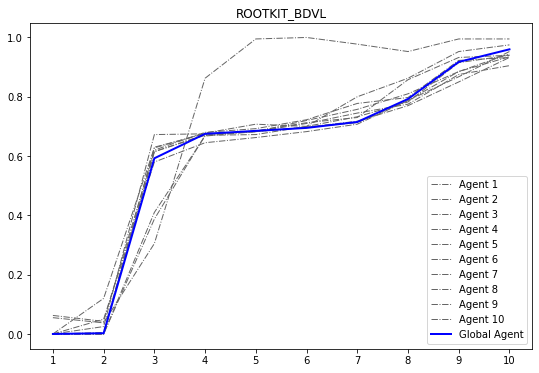

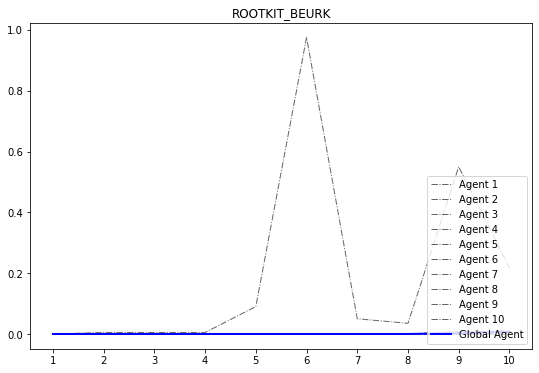

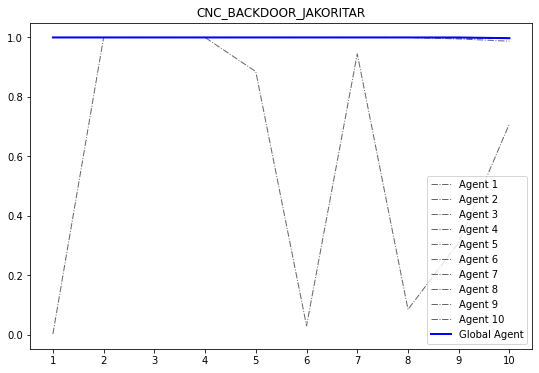

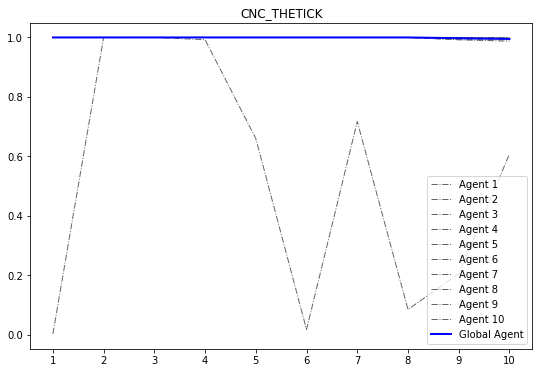

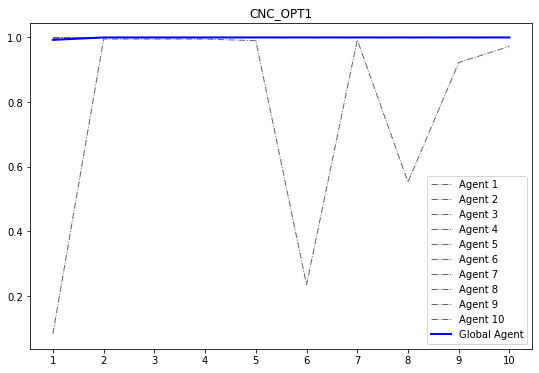

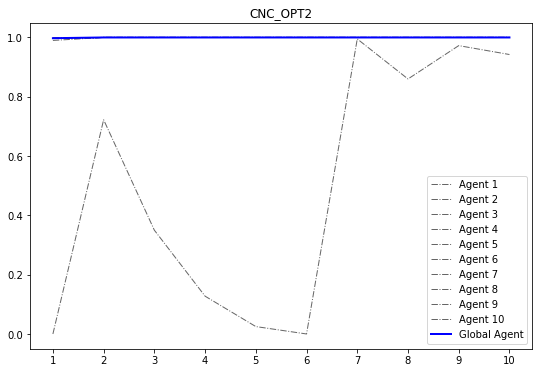

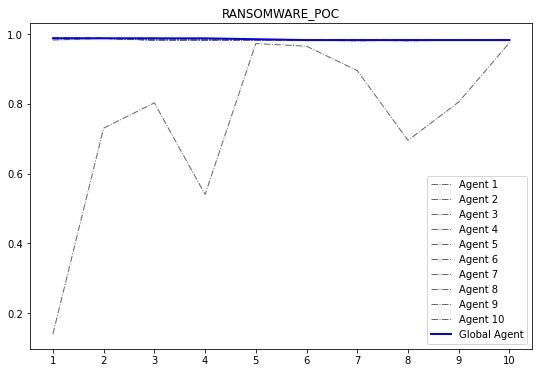

In [82]:
e1v1.plot_behavior_performances()

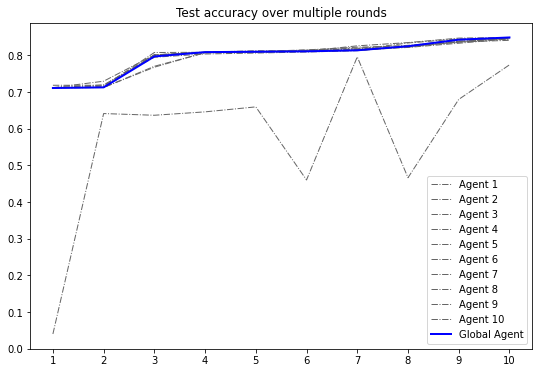

In [83]:
e1v1.plot_test_performances()

In [90]:
def plot_test_performances(server):
    agents = list(map(lambda client: client.agent, server.clients))
    agents.append(server.global_agent)

    plt.figure(figsize=(9,6))
    for agent in agents:
        #print(agent.get_name())
        #print(agent.total_accuracies)
        #print(agent.mean_class_accuracies)
        #print("---------")
        #plt.ylim(0, 0.9)
        agent_id = agent.agent_id

        label = agent.get_name()
        x = list(agent.total_accuracies.keys())
        y = agent.total_accuracies.values()

        if agent_id == 0:
            color='blue'
            linestyle='solid'
            linewidth=2
        else:
            color='#666666'
            linestyle='dashdot'
            linewidth=1
            #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

        #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    #plt.title('Test Accuracy over multiple Training Rounds')
    print(f"Test Accuracy over multiple Training Rounds")
    plt.xlabel('Training Round')
    plt.ylabel('Test Accuracy')
    plt.xticks(x)
    #plt.ylim(top=1)
    plt.legend(loc="lower right")
    plt.show()

def plot_behavior_performances(server):
    agents = list(map(lambda client: client.agent, server.clients))
    agents.append(server.global_agent)

    non_normal_behaviors = [behavior for behavior in Behavior if behavior is not Behavior.NORMAL]
    for behavior in non_normal_behaviors:
        plt.figure(figsize=(9,6))
        for agent in agents:
            #print(agent.get_name())
            #print(agent.total_accuracies)
            #print(agent.mean_class_accuracies)
            #print("---------")
            agent_id = agent.agent_id

            label = agent.get_name()
            x = list(agent.behavior_accuracies[behavior].keys())
            #print(x)
            y = agent.behavior_accuracies[behavior].values()
            #print(y)

            if agent_id == 0:
                color='blue'
                linestyle='solid'
                linewidth=2
            else:
                color='#666666'
                linestyle='dashdot'
                linewidth=1
                #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
            plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)

            #plt.plot(x, y, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
        plt.xticks(x)
        print(f"Mitigation Performance for {behavior.name}")
        #plt.title(f"Mitigation Performance for {behavior.name}")
        plt.xlabel('Training Round')
        plt.ylabel('Test Accuracy')
        plt.ylim(0, 1.05)
        #plt.ylim(top=1)
        #plt.title(behavior.name)
        plt.legend(loc="lower right")
        plt.show()

Test Accuracy over multiple Training Rounds


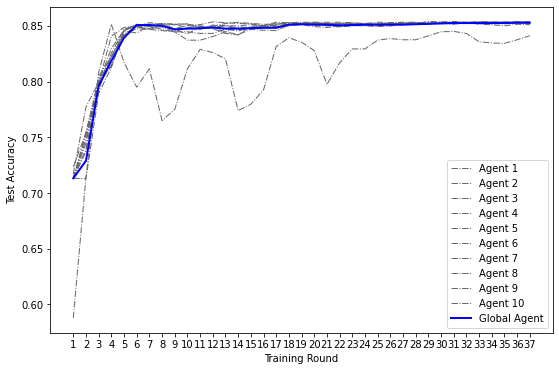

In [91]:
plot_test_performances(server)

Mitigation Performance for ROOTKIT_BDVL


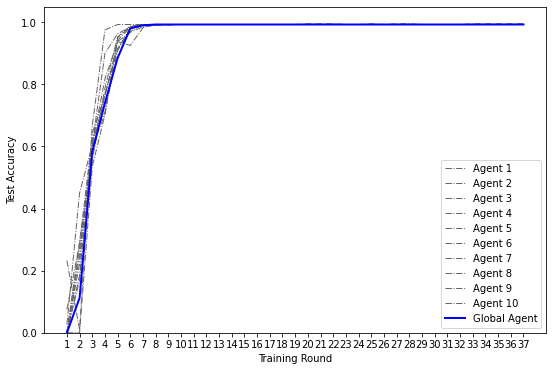

Mitigation Performance for ROOTKIT_BEURK


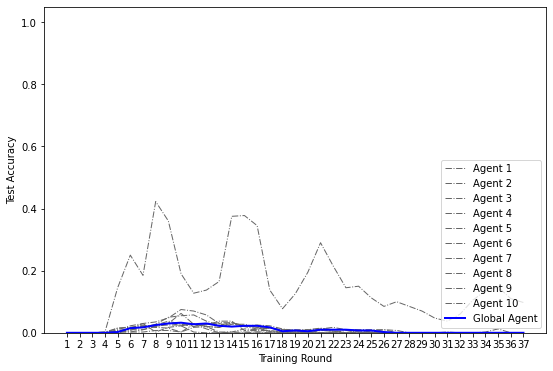

Mitigation Performance for CNC_BACKDOOR_JAKORITAR


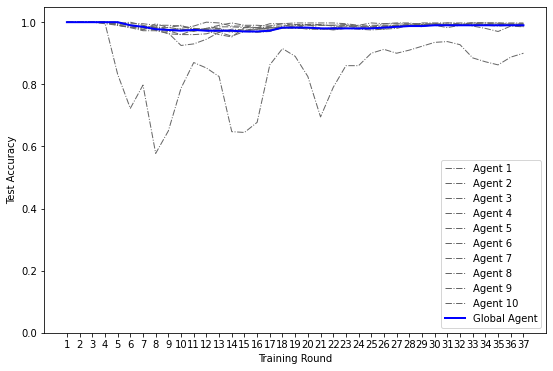

Mitigation Performance for CNC_THETICK


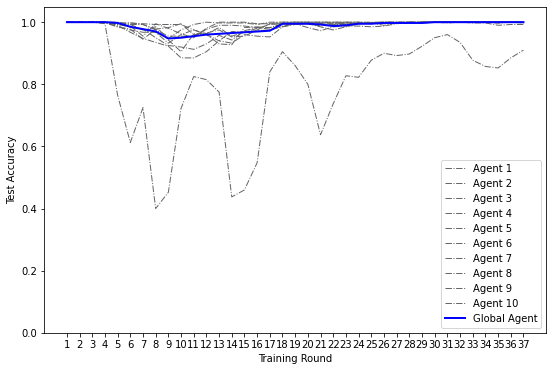

Mitigation Performance for CNC_OPT1


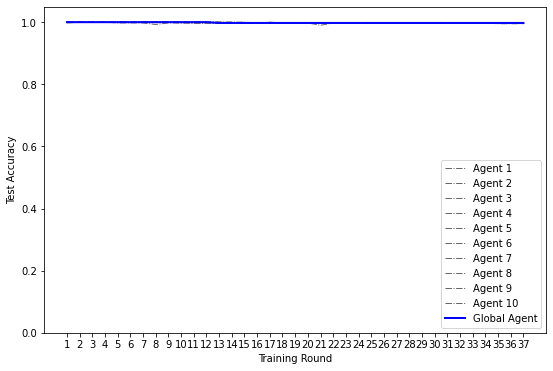

Mitigation Performance for CNC_OPT2


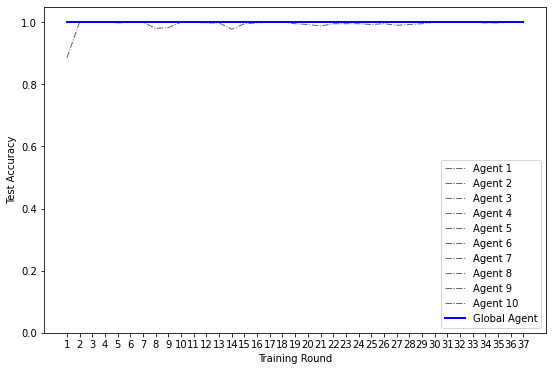

Mitigation Performance for RANSOMWARE_POC


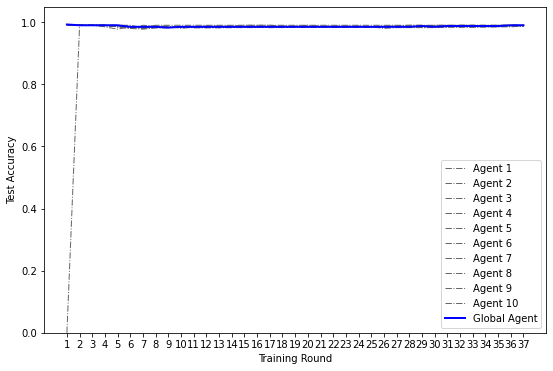

In [92]:
plot_behavior_performances(server)